# ADA Project : Milestone 2

## Into the male gaze...

Abstract

First, import the necessary libraries and define our data paths:

In [1]:
# Utilitaries

import pandas as pd
import numpy as np

#Data visualization
import matplotlib.pyplot as plt
import seaborn as sns
from  matplotlib.colors import LinearSegmentedColormap
%matplotlib inline

import math
import os

# External libraries needed for the project:

#!pip install stanza
#pip install deplacy
#pip install empath
#pip install thefuzz

#Natural language processing libraries:
import stanza
import deplacy
from thefuzz import process
from empath import Empath 
from CoreNLPanalysis import *

#PCA:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

#Avoid copy warnings:
import warnings
lexicon = Empath()

os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [28]:
warnings.filterwarnings('ignore')

# 1. Data importation

In [2]:
google_colab = False
if google_colab:
    data_folder = '/content/sample_data/'
else:
    data_folder = './Data/'

In [3]:
#Loading character metadata:
characters = pd.read_csv(data_folder + "character.metadata.tsv", sep='\t', header = None)
characters.columns = ('Wikipedia movie ID', 'Freebase movie ID', 'Movie release date',
              'Character name', 'Actor date of birth', 'Actor gender',
              'Actor height (in meters)', 'Actor ethnicity (Freebase ID)', 'Actor name', 
              'Actor age at movie release', 'Freebase character/actor map ID', 'Freebase character ID', 
              'Freebase actor ID')
characters['Movie release date'] = pd.to_datetime(characters['Movie release date'], errors = 'coerce').dt.year

# change all formats to datetime and keep the year only
# Many of the date formats are inconsistent. 
# Here we convert it all to just year as this is the temporal resolution in which we are interested

In [4]:
#Loading movie metadata:
movies = pd.read_csv(data_folder + "movie.metadata.tsv", sep='\t', header = None)
movies.columns = ('Wikipedia movie ID' , 'Freebase movie ID' , 'Movie name' , 
                'Movie release date' , 'Movie box office revenue' , 
                'Movie runtime' , 'Movie languages' , 'Movie countries' , 'Movie genres')

movies['Movie release date'] = pd.to_datetime(movies['Movie release date'], errors = 'coerce').dt.year

In [5]:
# Loading plot summaries:
df_plot_summaries = pd.read_csv(data_folder + 'plot_summaries.txt', sep='\t')
df_plot_summaries.columns = ['Wikipedia movie ID', 'Plot Summary']
print("There are", len(df_plot_summaries), "plot summaries")

There are 42302 plot summaries


# 2. Preliminary Analysis

#### Characters Preliminary

In [6]:
movies.sample(3)

,Wikipedia movie ID,Freebase movie ID,Movie name,Movie release date,Movie box office revenue,Movie runtime,Movie languages,Movie countries,Movie genres
76557,33910742,/m/0hn9fhm,The Builder,NaN,NaN,NaN,{},{},"{""/m/07s9rl0"": ""Drama""}"
62075,35996674,/m/0hhgh69,Epic,2013.0,NaN,NaN,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/0hqxf"": ""Family Film"", ""/m/01hmnh"": ""Fant..."
14696,31916334,/m/0c0l41c,To Have & to Hold,1996.0,NaN,99.0,"{""/m/02h40lc"": ""English Language""}","{""/m/0chghy"": ""Australia""}","{""/m/01jfsb"": ""Thriller"", ""/m/02n4kr"": ""Mystery""}"


In [7]:
print('There are {} entries in the movies dataset'.format(len(movies)))

There are 81741 entries in the movies dataset


In [8]:
for name, values in movies.items():
    print ('{:.4} % of movies have an associated {}'.format(100 * len(values.loc[values.notnull()])/len(values), name))

100.0 % of movies have an associated Wikipedia movie ID
100.0 % of movies have an associated Freebase movie ID
100.0 % of movies have an associated Movie name
91.56 % of movies have an associated Movie release date
10.28 % of movies have an associated Movie box office revenue
74.98 % of movies have an associated Movie runtime
100.0 % of movies have an associated Movie languages
100.0 % of movies have an associated Movie countries
100.0 % of movies have an associated Movie genres


**Note :** Any analysis based on the movie revenue (as a measure of success) will need extra information, as probably basing the study only in 10% of the data is not enough.



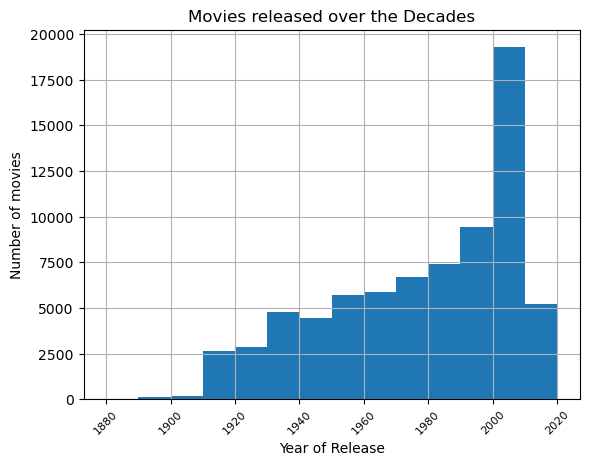

In [9]:
fig, ax = plt.subplots()
ax = movies['Movie release date'].hist(bins = range(1880,2030,10), grid = True, xlabelsize = 8 ,xrot = 45)
plt.xlabel('Year of Release')
plt.ylabel('Number of movies')
plt.title('Movies released over the Decades');

**Note:** On 16 December 2014, Google announced that it would shut down Freebase over the succeeding six months and help with the move of the data from Freebase to Wikidata. Data collection does not go through the entire 2010's decade

In [10]:
print('The dataset is comprised of movies with known releases between {0:n} and {1:n} '.format(movies['Movie release date'].min(), 
                                                                                               movies['Movie release date'].max()))

The dataset is comprised of movies with known releases between 1888 and 2016 


In [11]:
rmovies = movies[movies['Movie box office revenue'].notnull()]

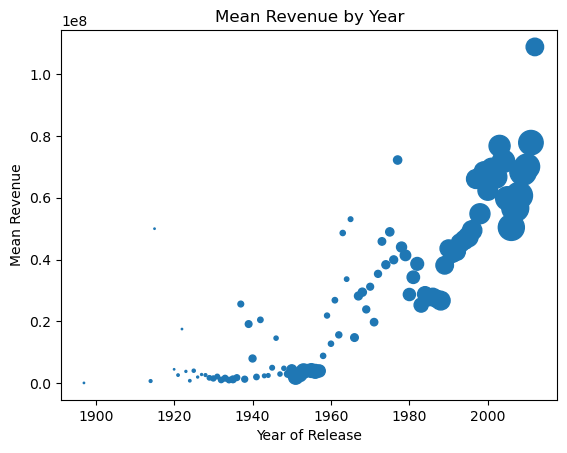

In [12]:
r_by_year = rmovies.groupby("Movie release date")['Movie box office revenue'].agg(['mean','size']).reset_index()
r_by_year.plot(kind = 'scatter', x = 'Movie release date', y = 'mean',s = 'size')
plt.title('Mean Revenue by Year')
plt.ylabel('Mean Revenue')
plt.xlabel('Year of Release');

From the above plot we see that the mean revenues increase over time. It would be interesting to normalize this by inflation or perhaps some share of GDP. We also see that there is much more data present in the later years (dot size scaled by amount of revenues averaged to form datapoint. 1897 - 1 movie revenue, 2008 - 367 movie revenues)

In [13]:
def correct_countries(x):
    if len(x)>2:
        x= x.split(':')[1][0:-1]
        res = x.split('"')[1]
    else:
        res = 'NA' 
    return res

movies["Movie countries corrected"]= movies["Movie countries"].apply(lambda x: correct_countries(x))

In [18]:
c_movies_filt = pd.DataFrame(movies.groupby(["Movie release date","Movie countries corrected"]).size()).reset_index()
c_movies_filt = c_movies_filt.set_axis(["Movie release date", "Movie countries corrected", 'Count'], axis='columns')
c_movies_filt

,Movie release date,Movie countries corrected,Count
0,1888.0,United Kingdom,1
1,1889.0,United Kingdom,1
2,1890.0,United Kingdom,1
3,1890.0,United States of America,1
4,1891.0,NA,2
...,...,...,...
4109,2014.0,United States of America,4
4110,2015.0,NA,2
4111,2015.0,United States of America,2
4112,2016.0,NA,1


In [19]:
most_common_count = movies.groupby(["Movie countries corrected"]).size().reset_index()
most_common_count = most_common_count.set_axis(["Country", "Number of movies"], axis='columns')
most_common_count.drop(most_common_count[most_common_count['Country'] == 'NA'].index, inplace = True)
most_common_count = most_common_count.sort_values("Number of movies", ascending=False)[0:10]
most_common_count

,Country,Number of movies
124,United States of America,34118
51,India,8294
123,United Kingdom,5477
40,France,3996
60,Japan,2321
58,Italy,1925
21,Canada,1471
3,Argentina,1291
48,Hong Kong,1120
5,Australia,874


In [20]:
top10_country_data = c_movies_filt[c_movies_filt['Movie countries corrected'].isin(most_common_count['Country'])]

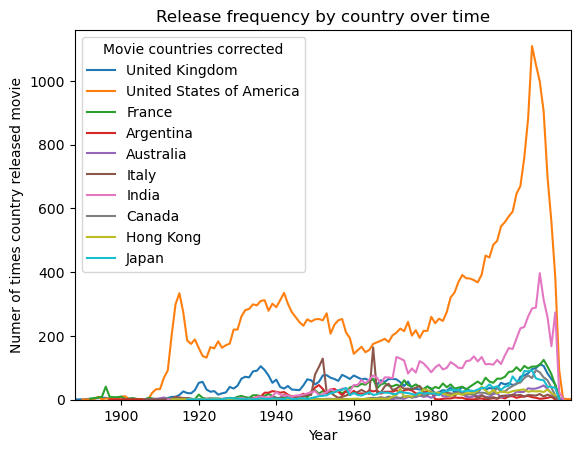

In [21]:
sns.lineplot(x='Movie release date', y='Count',data = top10_country_data, hue = 'Movie countries corrected', legend=True)
plt.xlabel("Year")
plt.ylabel("Numer of times country released movie")
plt.title("Release frequency by country over time")
plt.ylim([0,top10_country_data['Count'].max()+50])
plt.xlim([top10_country_data['Movie release date'].min(), top10_country_data['Movie release date'].max()]);
#plt.yscale('log')

#### Characters Preliminary

In [22]:
characters.sample(3)

,Wikipedia movie ID,Freebase movie ID,Movie release date,Character name,Actor date of birth,Actor gender,Actor height (in meters),Actor ethnicity (Freebase ID),Actor name,Actor age at movie release,Freebase character/actor map ID,Freebase character ID,Freebase actor ID
58834,24301781,/m/07scj0r,1964.0,NaN,1935-01-09,M,NaN,NaN,Bob Denver,NaN,/m/07ssxhy,NaN,/m/018hgr
318594,3578467,/m/09mrk_,1977.0,NaN,1933-11-09,M,NaN,NaN,Robert Gillespie,43.0,/m/0k1n79,NaN,/m/0ck208
257826,14781533,/m/04gh3n0,2008.0,NaN,1955-01-18,M,1.85,/m/09vc4s,Kevin Costner,53.0,/m/0gxk9y4,NaN,/m/0127m7


In [23]:
print('There are {} entries in the characters dataset'.format(len(characters)))

There are 450669 entries in the characters dataset


In [24]:
for name, values in characters.items():
    print ('{:.4} % of characters have an associated {}'.format(100 * len(values.loc[values.notnull()])/len(values), name))

100.0 % of characters have an associated Wikipedia movie ID
100.0 % of characters have an associated Freebase movie ID
97.78 % of characters have an associated Movie release date
42.78 % of characters have an associated Character name
76.45 % of characters have an associated Actor date of birth
89.88 % of characters have an associated Actor gender
34.35 % of characters have an associated Actor height (in meters)
23.53 % of characters have an associated Actor ethnicity (Freebase ID)
99.73 % of characters have an associated Actor name
64.92 % of characters have an associated Actor age at movie release
100.0 % of characters have an associated Freebase character/actor map ID
42.78 % of characters have an associated Freebase character ID
99.82 % of characters have an associated Freebase actor ID


In [25]:
#we see lots of NA ages at release... lets drop those
char_filt_age = characters[characters['Actor age at movie release'].notnull()]

In [26]:
char_filt_age.loc[char_filt_age['Actor age at movie release']<0]

,Wikipedia movie ID,Freebase movie ID,Movie release date,Character name,Actor date of birth,Actor gender,Actor height (in meters),Actor ethnicity (Freebase ID),Actor name,Actor age at movie release,Freebase character/actor map ID,Freebase character ID,Freebase actor ID
767,15007384,/m/03h4h5p,1934.0,NaN,1963-11-07,NaN,NaN,NaN,Franck Dubosc,-29.0,/m/0bwb9k3,NaN,/m/01wlly9
2286,2553539,/m/07mlsy,1918.0,NaN,1931-03-25,M,NaN,NaN,Tom Wilson,-12.0,/m/0jsqm1,NaN,/m/0382zh
3892,5917218,/m/0fdf3y,1965.0,NaN,1983-03-03,F,1.75,NaN,Kim Smith,-18.0,/m/04mb5kf,NaN,/m/03pjkv
6666,73930,/m/0jsjm,1924.0,Robert,1972-11-07,M,1.80,NaN,Jason London,-48.0,/m/01xrptw,/m/02nwfsk,/m/04kdmg
7188,21242801,/m/05bzjwj,1955.0,NaN,1973-08-01,M,1.79,/m/03ttfc,Eduardo Noriega,-17.0,/m/0cg2f0f,NaN,/m/0bkkw0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
446570,3642891,/m/09rsyj,1999.0,Tess,2936-12-24,F,NaN,NaN,J.J. McColl,-937.0,/m/0l2rdfz,/m/0l2rdg1,/m/0l2rdg8
446581,25868401,/m/09v6ykm,1955.0,NaN,1967-05-31,F,1.67,/m/03ts0c,Sandrine Bonnaire,-12.0,/m/04j05tr,NaN,/m/07wn_5
446583,8595532,/m/02799cv,1944.0,NaN,1947-05-28,M,NaN,NaN,Kevin O'Shea,-3.0,/m/02vcqnq,NaN,/m/02q384f
446816,1276915,/m/04pg6m,1941.0,NaN,1957-04-19,M,NaN,NaN,Tony Martin,-15.0,/m/0cg164j,NaN,/m/07q_fg


**Note:** In the dataframe above we see 381 instances of negative ages. By taking the difference between the actor date of birth and movie release date we realize that the actor age is correct in magnitude but not in sign. Below, we correct the column by taking its absolute value.

In [27]:
char_filt_age.loc[char_filt_age['Actor age at movie release'] < 0, 
                  'Actor age at movie release'] = char_filt_age['Actor age at movie release'].abs()

In [28]:
print('Only {:.4} % of charactors have an associated actor age at release'.format(100 * len(char_filt_age)/len(characters)))

Only 64.92 % of charactors have an associated actor age at release


In [29]:
char_age_grouped = char_filt_age.groupby(["Movie release date", "Actor gender"])['Actor age at movie release'].agg(['mean','size']).reset_index()


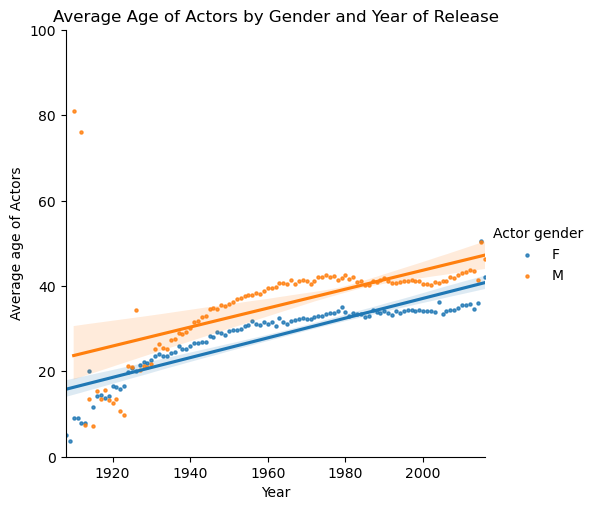

In [30]:
# Here we break down the analysis by gender, 

sns.lmplot(x="Movie release date", y='mean',data = char_age_grouped, hue = 'Actor gender', scatter_kws={"s":5})
plt.xlabel("Year")
plt.ylabel("Average age of Actors")
plt.title("Average Age of Actors by Gender and Year of Release")
plt.ylim([0,100])
plt.xlim([char_age_grouped["Movie release date"].min(),char_age_grouped["Movie release date"].max()]);

In [31]:
avg_age_M = round(char_filt_age.loc[char_filt_age['Actor gender'] == 'M']['Actor age at movie release'].mean(),0)
avg_age_F = round(char_filt_age.loc[char_filt_age['Actor gender'] == 'F']['Actor age at movie release'].mean(),0)
print('The average age for male actors is ', avg_age_M, ', whereas for actresses it is ', avg_age_F)

The average age for male actors is  40.0 , whereas for actresses it is  33.0


In the above figure we are displaying the average age at movie release for female and male actors, as well as the linear regression of the average age evolution over time. The shaded areas represent the 95% confidence interval for the regression.

It is interesting to note that males tend to be older than women in cinema over the last hundred years (at least since 1940). This difference observed in the plot is also confirmed by the computed overall average age at realease for both genders (40 for men compared to 33 for women). 

We can also observe a tendency to employ older actors in movies. One of the hypothesis for this fact is that the age at release data is lacking for older actors at the beginning of the 20th century. Record keeping was not as good as it is now. This could be an explanation for the fact that the data we do have on actors with roles in the early 20th century are all quite young - ie they lived long enough to enter modern database management. 

In [32]:
char_gen = pd.DataFrame(characters.groupby(['Movie release date', 'Actor gender'])['Actor gender'].agg('size')).rename(columns={'Actor gender' : 'Count'}).reset_index()
char_gen['Gender Percentage'] = char_gen['Count'] / char_gen.groupby('Movie release date')['Count'].transform('sum')*100
char_gen = char_gen.loc[char_gen['Actor gender'] == 'F']
char_gen.head()

,Movie release date,Actor gender,Count,Gender Percentage
0,1888.0,F,2,50.000000
4,1894.0,F,1,25.000000
7,1896.0,F,5,55.555556
9,1897.0,F,2,66.666667
11,1898.0,F,1,25.000000


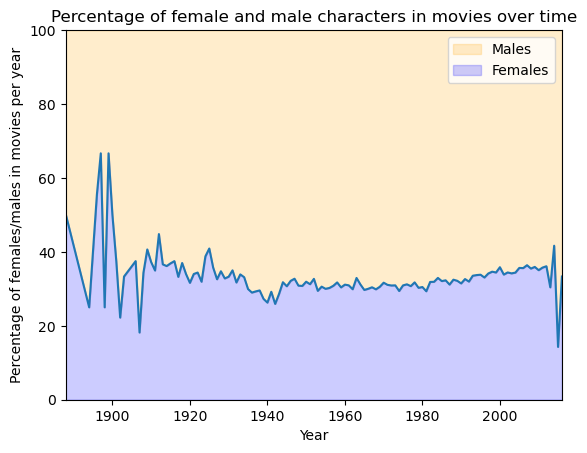

In [33]:
ax = sns.lineplot(x='Movie release date', y='Gender Percentage',data = char_gen, legend=True)
l1 = ax.lines[0]
x1 = l1.get_xydata()[:, 0]
y1 = l1.get_xydata()[:, 1]
ax.fill_between(x1, y1, 100, color="orange", alpha=0.2, label = 'Males')

ax.fill_between(x1, y1, color="blue", alpha=0.2, label = 'Females')
plt.xlabel("Year")
plt.ylabel("Percentage of females/males in movies per year")
plt.title("Percentage of female and male characters in movies over time")
plt.ylim([0,100])
plt.xlim([char_gen['Movie release date'].min(), char_gen['Movie release date'].max()])
plt.legend()

#plt.yscale('log')

We see more dynamic behavior in the earlier years. This is due to small sample sizes which lead to large spikes in % for small deviations. We see it stabilize for a majority of the graph before once again entering erratic territory in the last years (data collection was limited in the 2010's). The most obvious takeaway is that male characters are more common than female characters

In [34]:
# Checking when either character name or Freebase movie ID are missing:
print('Missing "character names" in character metadata: %d' %characters['Character name'].isnull().sum())
print('Missing "Freebase character" IDs in character metadata: %d' %characters['Freebase character ID'].isnull().sum())
print('We can see that the number of missing character names ≈ missing Freebase character IDs')
print('There are 10 characters where we have a "Freebase character ID" but not "character names"')
# Checking when both "Character name" and "Freebase character ID are missing":
characters.loc[characters['Character name'].isnull() & characters['Freebase movie ID'].isnull()]
missing_both_IDs = sum(characters.iloc[:, [3, 11]].isnull().all(1))
print('Missing Character name AND Freebase character ID: %d' %missing_both_IDs)
# Checking characters for which we don't have that character name buit we have both the Freebase character/actor map ID and Freebase actor ID
characters.iloc[:, [3, 11]].isnull().all(1) # 4th column and 11th column
poss_recov = sum(characters.iloc[:, [3]].isnull().all(1) & characters.iloc[:, [10, 12]].notnull().all(1))
print('Missing character name but known Freebase character/actor map ID and Freebase actor ID: %d' %poss_recov)

Missing "character names" in character metadata: 257875
Missing "Freebase character" IDs in character metadata: 257865
We can see that the number of missing character names ≈ missing Freebase character IDs
There are 10 characters where we have a "Freebase character ID" but not "character names"
Missing Character name AND Freebase character ID: 257865
Missing character name but known Freebase character/actor map ID and Freebase actor ID: 257389


The previous analysis highlights the possibility of using the available Freebase IDs in order to recover a substantial amount to character names. The Freebase character/actor map will link the Freebase actor ID to the roles that the specific actor will have performed. As a result, we will be able to extract the Freebase character IDs, thus the missing character names. 

In [35]:
''' Merging character with movie metadata with an inner join. We do an inner join 
because there are movies in the movie metadata for which we do not 
have any character information in character metadata and vice versa.
For the future analysis we need both information about the characters
and movie in which they appear'''

df_char_movie = pd.merge(left= characters, right= movies, how='inner', on= ['Wikipedia movie ID', 'Freebase movie ID', 'Movie release date'])
print('The total number of characters that we obtain from the inner merge is: %d' %len(df_char_movie))

The total number of characters that we obtain from the inner merge is: 450669


In [36]:
movies_with_characters = df_char_movie.groupby(['Wikipedia movie ID']).agg('size')
print('The resulting number of movies from the merge of characters and movies is: %d'%len(movies_with_characters))

The resulting number of movies from the merge of characters and movies is: 64330


In [37]:
# Computing the total number of characters and the number of character names we have in our dataframe
char_names_per_movie = df_char_movie.groupby('Wikipedia movie ID')['Character name'].count() # extracts number of characters we have (i.e. not coun ting NaNs)
total_characters_per_movie = df_char_movie.groupby(['Wikipedia movie ID'])['Character name'].agg(['size'])

In [38]:
df_character_missing_stats = pd.merge(total_characters_per_movie, char_names_per_movie, on='Wikipedia movie ID')
df_character_missing_stats['n°_missing_characters'] = df_character_missing_stats['size'] - df_character_missing_stats['Character name']
df_character_missing_stats['percentage_missing'] = round(100 * df_character_missing_stats['n°_missing_characters'] / df_character_missing_stats['size'], 2) # computing percentages of missing character names
df_character_missing_stats['percentage_available'] = 100 - df_character_missing_stats['percentage_missing']
df_character_missing_stats = df_character_missing_stats.rename(columns={'size': 'total_n°_characters (incl. NaN)'})
df_character_missing_stats = df_character_missing_stats.rename(columns={'Character name': 'character_names (excl. NaN)'})
df_character_missing_stats.head()

,total_n°_characters (incl. NaN),character_names (excl. NaN),n°_missing_characters,percentage_missing,percentage_available
Wikipedia movie ID,,,,,
330,4,0,4,100.0,0.0
3217,14,14,0,0.0,100.0
3333,14,0,14,100.0,0.0
3746,15,15,0,0.0,100.0
3837,20,16,4,20.0,80.0


In the dataframe above we obtain:
- the total amount of characters in a specific movie
- the number of character names for a specific movie
- the percentage of the character names that are missing per movie
- the percentage of the character names that are available per movie

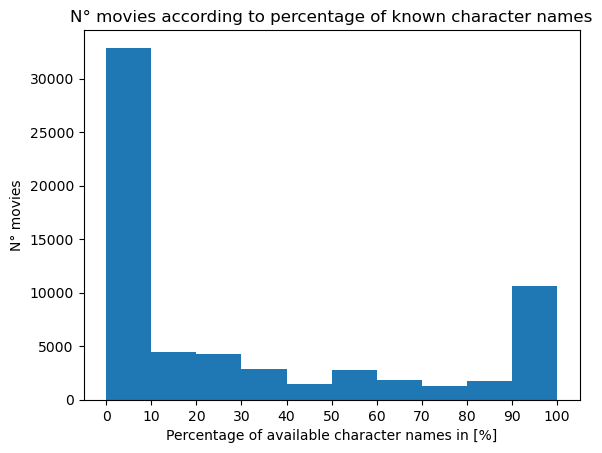

In [39]:
df_character_missing_stats['percentage_available'].hist(bins=10, grid=False)
plt.xticks(np.arange(0, 110, step=10))
plt.ylabel('N° movies')
plt.xlabel('Percentage of available character names in [%]')
plt.title('N° movies according to percentage of known character names')
plt.show()

For example: there are roughly 39 000 movies for which we have less than 10% of the character names.

In [40]:
# Let's calculate the percentage of movies for which we have at least 1 character name
# Assuming that the character name that would be available is the one of the main character.

more_1_char = df_character_missing_stats['character_names (excl. NaN)'][df_character_missing_stats['character_names (excl. NaN)'] >= 1].count()
perc_1_char = 100*more_1_char/64329

print('The total number of movies where we have at least one character name is: %d' %more_1_char)
print('The percentage of movies for which we have at least one character name is: %d' %perc_1_char, '%')

The total number of movies where we have at least one character name is: 32571
The percentage of movies for which we have at least one character name is: 50 %


# CoreNLP

In [42]:
'''Now we want to proceed to the analysis of the plots using the CoreNLP model. 
For that we first compare the plot information with the character and movie information, 
to not analyse plots we can not link to other data. The final dataframe contains only the Wikipedia Modie ID and Plot Summaries
which are related to movie and character data'''

df_char_movie_plot = pd.merge(left= df_char_movie, right= df_plot_summaries, how='inner', on= ['Wikipedia movie ID'])
df_plots_filt = df_char_movie_plot[['Wikipedia movie ID','Plot Summary']].drop_duplicates().reset_index()
df_plots_filt = df_plots_filt.drop(columns = ['index'])
df_plots_filt

,Wikipedia movie ID,Plot Summary
0,975900,"Set in the second half of the 22nd century, th..."
1,261236,"Eva, an upper class housewife, becomes frustra..."
2,2238856,The structure of the film consists of several ...
3,18296435,"Serap, a young actress with a strong, lively p..."
4,32456683,"Otto Brosowski, a communist miner, writes to t..."
...,...,...
37773,22545667,Gracie and Laurie are lovers who together fo...
37774,31627556,"Kara , George , and Enzo are 3 best friends w..."
37775,30553937,A daytime soap opera star has to deal with his...
37776,12476867,The movie is about a teenage girl who loves ho...


In [ ]:
stanza.download('en') # download English model

In [ ]:
nlp = stanza.Pipeline(lang='en', processors='tokenize, mwt, pos, lemma, depparse, ner')

**Note:** The two following cells should not be ran locally, because of the computational cost. Instead, we used Google Colab with GPU option to run the NLP analysis and create the resulting dataset. Here we keep it for a good understanding of the workflow. The result of the analysis is in the Data folder, and we can import it directly from there.

In [ ]:
# The Analyse_Plots function is in a separated python file,
#to avoid any information not critical to the understanding of our analysis
#It is then imported from CoreNLPanalysis.py
df_NLP = Analyse_Plots(df_plots_filt, nlp)  

In [ ]:
df_NLP.to_csv(data_folder + "Plot_NLP_Analysis.csv", sep='\t', header=None)

In [ ]:
# Loading the data obtained from the NLP pipeline:
df_1 = pd.read_csv(data_folder + "Plot_NLP_Analysis_0_14100.csv", sep='\t', header = None)
df_2 = pd.read_csv(data_folder + "Plot_NLP_Analysis_14101_23201.csv", sep='\t', header = None)
df_3 = pd.read_csv(data_folder + "Plot_NLP_Analysis23202-42302.csv", sep='\t', header = None)
df_1 = df_1.drop(columns=0)
df_2 = df_2.drop(columns=0)
df_3 = df_3.drop(columns=0)
clusters_df = pd.concat([df_1, df_2, df_3], ignore_index=True)
clusters_df.columns = ('Wikipedia movie ID', 'Character partial name', 'Agent Verbs', 'Patient Verbs', 'Attributes')

In [ ]:
clusters_df

In [ ]:
df_char_movie_names = df_char_movie[['Wikipedia movie ID','Character name']].dropna()
df_char_movie_names['All_names'] = df_char_movie_names.groupby(['Wikipedia movie ID'], 
            as_index = True)['Character name'].transform(lambda x: ','.join(x))
df_char_movie_names = df_char_movie_names[['Wikipedia movie ID', 'All_names']].drop_duplicates()
df_char_movie_names['All_names'] = [x.strip('()').split(',') for x in df_char_movie_names['All_names']]

In [ ]:
clusters_df = clusters_df.merge(df_char_movie_names, how = 'inner', on = 'Wikipedia movie ID')
clusters_df.head(3)

### Case study example over one movie : "Bhagwan Dada", movie ID 10644072 


In [ ]:
#Let's first extract the beginning of the plot summary of Bhagwan Dada, movie ID 10644072.

text_extract_10644072 = '''A villager new to the big city – Bhagwaan  – turns to crime to avoid starvation. He is drawn into the gang of slum crime lord ‘dada’ Shambu  where he falls into every crime but one: violence against women. When an impoverished but honourable young widow hangs herself after being raped by Shambu Dada, the cries of her orphaned baby awaken Bhagwaan’s soul. He rebels against his former master. Bhagwaan vows to atone for his formerly evil life, and adopts the orphaned baby as his own son. The innocent young boy becomes Bhagwaan’s source of personal redemption and the inspiration for all that he does. 12 years later the man now lovingly hailed as “Bhagwaan Dada” has transformed the former crime-ridden slum into a safe and happy neighbourhood - Shantinagar - where his adopted son Govinda  has become the pride and joy of the whole community. Despite his own dark past, this loving father has worked hard to raise the boy as a good person with sound moral values. At this time, Bhagwaan chances to rescue another naïve young man new to the big city – Swaroop  – when Shambu Dada’s gang steal all Swaroop’s money. Impressed with Swaroop’s education as well as the similarity of situation to his own arrival in the city years before, Bhagwaan takes the “innocent and simple” villager under his protective wing. He arranges a good job, even brings Swaroop home to live with himself and his son, young Govinda. Swaroop and Bhagwaan claim each other as ‘brothers’.'''
text_extract_10644072

In [ ]:
# Then, we run the pipeline over the plot summary which will run annotation over each sentence of the plot:
doc_10644072 = nlp(text_extract_10644072)

In [ ]:
#Then, we can have a look at the dependencies of the words between each other:
print(*[f'id: {word.id}\tword: {word.text}\thead id: {word.head}\thead: {sent.words[word.head-1].text if word.head > 0 else "root"}\tdeprel: {word.deprel}' for sent in doc_10644072.sentences for word in sent.words], sep='\n')

As we can see, the result of these show each tokenized word of the sentence, their id, and their dependency relationship with other words and their ids in the same sentence. The deprel type relies on the Stanford typed dependencies representation "which was designed to provide a simple description of the grammatical relationships in a sentence that can easily be understood and effectively used by people
without linguistic expertise who want to extract textual relations" (Marneffe and Manning, 2008).

In [ ]:
#We can visualize the results of these annotations with the first sentences of the plot summary with the deplacy library:
deplacy.render(doc_10644072)
#Here, it also shows the position of the word, meaning the type of word it is:

In [ ]:
#Another type of visualization, maybe more visual, with port=None to be visualized directly within the notebook is the following:
deplacy.serve(doc_10644072, port=None, RtoL=False)

In [ ]:
#Then, we select the plot summary within all the plots, to demonstrate a typical output we get from our pipeline:
plot_10644072 = df_plots_filt[df_plots_filt['Wikipedia movie ID']==10644072].reset_index()
plot_10644072

In [ ]:
# This may take a lot of time to run (4 hours or more without google colab GPU) if you don't select a subset of plot summaries:
# Here, we select the movie ID of our example and it returns us a dataframe with all the characters (entities) found in the plot summary
# with their corresponding agent verbs, patient verbs and attributes:
df_NLP = Analyse_Plots(plot_10644072, nlp)  
df_NLP

In [ ]:
pd.set_option('display.max_colwidth', None)
for elem in ['Shambu', 'Bhagwaan', 'Bijli','Madhu']:
    print(elem,'\'s attributes in the movie plot correspond to :', df_NLP.loc[df_NLP['Character_Name']==elem]['Attributes'].values)
    print(elem,'\'s agent verbs, meaning verbs for which he\'s taking the action in the movie plot correspond to :', df_NLP.loc[df_NLP['Character_Name']==elem]['Agent Verbs'].values)
    print(elem,'\'s patient verbs, meaning verbs for which he is the action\'s subject in the movie plot correspond to :', df_NLP.loc[df_NLP['Character_Name']==elem]['Patient Verbs'].values)
    print('    ')

Here, we can see that it depicts a quite satisfying big picture of the character, where we can later analyse the lexical field of the words employed in the plot summary to describe him to define the archetype of this character. We can clearly retain from our analysis that Shambu holds a negative and violent description of himself depicted as a fugitive and evil master of the gang Bhagwaan was involved into. Bhagwaan on the contrary is correctly defined in the opposite way in our analysis by his 'soul' and thirst of revenge against his former master. Of course, only the archetype can be deduced from our list of attributes and verbs and not the meaning and relation between the characters, but this will help us to do archetypes comparison between character's genders later in the analysis. Indeed, Bijili and Madhu, both feminine characters, have much less verbs and attributes compared to previous masculine characters and their corresponding verbs are more on the 'victim' side: manages, confesses, help, as well as their attributes: sex worker, attraction, streetwalker etc. Of course, this concerns only one movie and cannot be generalized yet but we are confident about our results and can now move on to merge our outputs of the NLP pipeline with corresponding character names and movie IDs from character and movie metadata.

**Note:** Same as previously, we will not run those following cells, but they are useful to understand where our data comes from.

In [ ]:
def matching(col1, col2):
    if process.extractOne(col1, list(col2))[1]>80:
        res = process.extractOne(col1, list(col2))[0]    
    else:
        res = 'Not found'
    return res

clusters_df['Full_name'] = clusters_df.apply(lambda x: matching(x['Character partial name'],
                                                                            x['All_names']), axis=1)
clusters_df.tail(50)

In [ ]:
char_df = clusters_df.loc[clusters_df['Full_name'] != 'Not found']

In [ ]:
categories = ['Agent Verbs', 'Patient Verbs', 'Attributes']

for i,cat in enumerate(categories):
    rem = char_df[cat] == '0.0'
    char_df.loc[rem, cat] = char_df.loc[rem, cat].replace('0.0', '')
char_df['All_Agent_Verbs'] = char_df.groupby(['Full_name'])['Agent Verbs'].transform(lambda x: ','.join(x))
char_df['All_Patient_Verbs'] = char_df.groupby(['Full_name'])['Patient Verbs'].transform(lambda x: ','.join(x))
char_df['All_Attributes'] = char_df.groupby(['Full_name'])['Attributes'].transform(lambda x: ','.join(x))

In [ ]:
char_df = char_df[['Wikipedia movie ID', 'Full_name', 'All_Agent_Verbs', 'All_Patient_Verbs', 'All_Attributes']]

In [ ]:
char_df.to_csv(data_folder + "Characters_Matched_DF_Clean.csv", sep='\t', header=None)

## 3- Sentiment Analysis

In [43]:
CMdf = pd.read_csv(data_folder + 'Characters_Matched_DF_Clean.csv', sep='\t',index_col = 0)
CMdf.columns = ['Wikipedia movie ID', 'Character name', 'Agent Verbs', 'Patient Verbs', 'Attributes']
CMdf.reset_index(inplace = True,drop=True)
CMdf.drop_duplicates(inplace = True)

FileNotFoundError: [Errno 2] No such file or directory: './Data/Characters_Matched_DF_Clean.csv'

In [ ]:
CMdf = pd.merge(left= CMdf, right=df_char_movie, how='inner', on= ['Wikipedia movie ID', 'Character name'])

In [ ]:
CMdf_c = CMdf[['Wikipedia movie ID','Character name','Actor gender','Agent Verbs','Patient Verbs','Attributes']]

## Columns kept:
In this section, we extract the following columns for each character:
We keep only features such as for the preliminary sentiment analysis: 
- `Wikipedia movie ID`: ID of the movie from wikidata
- `Character name`: character name associated with verbs and attributes
- `Actor gender`
- `Agent Verbs`
- `Patient Verbs`
- `Attributes`

However, for later analysis, we would want to add other interesting features such as:
- `Movie release date`: the release date of the movie the character is from
- `nbr_words`: median of number of words in the plot summary corresponding to the movie ID
- `nbr_characters`: median of number of characters present in the movie (that we have in the final data!)

In [ ]:
#our lexicon.analyze requires a string of words with a space between them. 
# to transform current AV,PV, Attributes into required format: 

cols = ['Agent Verbs', 'Patient Verbs', 'Attributes']

for i in cols:
    CMdf_c[i] = CMdf_c[i].str.replace(',' ,' ')
    CMdf_c[i] = CMdf_c[i].str.replace('[' ,'')
    CMdf_c[i] = CMdf_c[i].str.replace(']' ,'')
    CMdf_c[i] = CMdf_c[i].str.replace("'" ,'')

In [ ]:
CMdf_c.sample(10)

## Feature extraction:
-  `scores` returned by the `analyze` function of the `Empath library` for different lexical categories. We choose these categories to cover a wide range of lexical fields for the purpose of our data analysis and obtain a score for each one of them. The whole list of categories of this library can be found following this link: https://github.com/Ejhfast/empath-client/blob/master/empath/data/categories.tsv.
- `Richness of the vocabulary`, that we compute by counting the median number of different words in the attributes, agent and patient verbs for women and men.
Other informations:
For later:
- `Top10Words`: presence or absence of verbs or attributes in the top 10 words occurring the most (make categories of them ? such as top10 violence, top10 sex etc)

These features could be added to the columns of the previous dataframe for each character but this would render the analysis too difficult for more than 15 000 characters !! For this reason, we first group the data in 2 groups: men and women, for a preliminary sentiment analysis but we want to extend this to common archetypes by gender later.

### 3.1  Lexical Analysis

In [ ]:
# grouping of the data by gender
# then we randomly mis data to create several subsets for male and female
# each subset will be a sample for the PCA analysis
women = CMdf_c.loc[CMdf_c['Actor gender'] == 'F']
men = CMdf_c.loc[CMdf_c['Actor gender'] == 'M']

In [ ]:
women.fillna('', inplace=True)
men.fillna('', inplace=True)

In [ ]:
for elem in ['Agent Verbs', 'Patient Verbs', 'Attributes']:

    women[elem] = women[elem].astype("string")
    men[elem] = men[elem].astype("string")

In [ ]:
print('The cleaned and processed lexical information contains {} male movie characters and {} female movie characters'.format(len(men),len(women)))

In [ ]:
men_agent_verbs = men['Agent Verbs'].str.split(expand=True).stack().value_counts().to_frame()
men_agent_verbs = men_agent_verbs.reset_index(level=0)
men_agent_verbs.set_axis(['agent_verb','verb_count'], axis='columns', inplace=True)
men_agent_verbs.head(10)

In [ ]:
women_agent_verbs = women['Agent Verbs'].str.split(expand=True).stack().value_counts().to_frame()
women_agent_verbs = women_agent_verbs.reset_index(level=0)
women_agent_verbs.set_axis(['agent_verb','verb_count'], axis='columns', inplace=True)
women_agent_verbs

In [ ]:
men_patient_verbs = men['Patient Verbs'].str.split(expand=True).stack().value_counts().to_frame()
men_patient_verbs = men_patient_verbs.reset_index(level=0)
men_patient_verbs.set_axis(['patient_verb','verb_count'], axis='columns', inplace=True)
men_patient_verbs.head()

In [ ]:
women_patient_verbs = women['Patient Verbs'].str.split(expand=True).stack().value_counts().to_frame()
women_patient_verbs = women_patient_verbs.reset_index(level=0)
women_patient_verbs.set_axis(['patient_verb','verb_count'], axis='columns', inplace=True)
women_patient_verbs.head()

In [ ]:
men_attributes = men['Attributes'].str.split(expand=True).stack().value_counts().to_frame()
men_attributes = men_attributes.reset_index(level=0)
men_attributes.set_axis(['attributes','attribute_count'], axis='columns', inplace=True)
men_attributes.head()

In [ ]:
women_attributes = women['Attributes'].str.split(expand=True).stack().value_counts()
women_attributes = women_attributes.reset_index(level=0)
women_attributes.set_axis(['attributes','attribute_count'], axis='columns', inplace=True)
women_attributes.head()

In [ ]:
# This dataframe shows the top agent verbs for men and women above a certain threshold (for either of the genders)
# The values have been normalised by the total number of words for each gender.

common_agent_verbs = pd.merge(left= men_agent_verbs, right=women_agent_verbs, how='inner', on= ['agent_verb'])
common_agent_verbs.set_axis(['agent_verb','verb_count_men', 'verb_count_women'], axis='columns', inplace=True)

total_verbs_men = sum(common_agent_verbs['verb_count_men'])
total_verbs_women = sum(common_agent_verbs['verb_count_women'])

common_agent_verbs['verb_count_men'] = 1000*common_agent_verbs['verb_count_men']/total_verbs_men
common_agent_verbs['verb_count_women'] = 1000*common_agent_verbs['verb_count_women']/total_verbs_women

common_agent_verbs = common_agent_verbs.loc[(common_agent_verbs['verb_count_men']>=10) | (common_agent_verbs['verb_count_women']>=10)]

common_agent_verbs

In [ ]:
# This dataframe shows the top patient verbs for men and women above a certain threshold (for either of the genders)
# The values have been normalised by the total number of words for each gender.

common_patient_verbs = pd.merge(left= men_patient_verbs, right=women_patient_verbs, how='inner', on= ['patient_verb'])
common_patient_verbs.set_axis(['agent_verb','verb_count_men', 'verb_count_women'], axis='columns', inplace=True)

total_patient_verbs_men = sum(common_patient_verbs['verb_count_men'])
total_patient_verbs_women = sum(common_patient_verbs['verb_count_women'])

common_patient_verbs['verb_count_men'] = 1000*common_patient_verbs['verb_count_men']/total_patient_verbs_men
common_patient_verbs['verb_count_women'] = 1000*common_patient_verbs['verb_count_women']/total_patient_verbs_women

common_patient_verbs = common_patient_verbs.loc[(common_patient_verbs['verb_count_men']>=10) | (common_patient_verbs['verb_count_women']>=10)]

common_patient_verbs

In [ ]:
# This dataframe shows the top attributes for men and women above a certain threshold (for either of the genders)
# The values have been normalised by the total number of words for each gender.

common_attributes = pd.merge(left= men_attributes, right=women_attributes, how='inner', on= ['attributes'])
common_attributes.set_axis(['attributes','attribute_count_men', 'attribute_count_women'], axis='columns', inplace=True)

total_attributes_men = sum(common_attributes['attribute_count_men'])
total_attributes_women = sum(common_attributes['attribute_count_women'])

common_attributes['attribute_count_men'] = 1000*common_attributes['attribute_count_men']/total_attributes_men
common_attributes['attribute_count_women'] = 1000*common_attributes['attribute_count_women']/total_attributes_women

common_attributes = common_attributes.loc[(common_attributes['attribute_count_men']>=10) | (common_attributes['attribute_count_women']>=10)]

common_attributes

### 3.2 Empath Analysis

In [ ]:
women_lex_av = pd.DataFrame([lexicon.analyze(women['Agent Verbs'].str.cat(sep = ' '))])
women_lex_pv = pd.DataFrame([lexicon.analyze(women['Patient Verbs'].str.cat(sep = ' '))])
women_lex_att = pd.DataFrame([lexicon.analyze(women['Attributes'].str.cat(sep = ' '))])

In [ ]:
men_lex_av = pd.DataFrame([lexicon.analyze(men['Agent Verbs'].str.cat(sep = ' '))])
men_lex_pv = pd.DataFrame([lexicon.analyze(men['Patient Verbs'].str.cat(sep = ' '))])
men_lex_att = pd.DataFrame([lexicon.analyze(men['Attributes'].str.cat(sep = ' '))])

In [ ]:
gendered_lex = pd.concat([women_lex_av, women_lex_pv, women_lex_att, men_lex_av, men_lex_pv, men_lex_att], ignore_index=True)
gendered_lex.rename(index={0:"Agent Verb [F]", 1:"Patient Verb [F]", 2: "Attribute [F]" ,3:"Agent Verb [M]", 4:"Patient Verb [M]", 5: "Attribute [M]"}, inplace = True)
gendered_lex

In [ ]:
gendered_lex['Total words'] = gendered_lex.sum(axis=1)
gendered_lex

In [ ]:
gendered_lex['Total words'] = gendered_lex.sum(axis=1)
gendered_lex
for col in gendered_lex.columns:
    gendered_lex[col] = gendered_lex[col]/gendered_lex['Total words']


In [ ]:
gendered_lex

In [ ]:
female_chars = women.sample(frac = 1, random_state = 1).reset_index()
male_chars = men.sample(frac = 1, random_state = 1).reset_index()
idx_f = np.arange(0, len(female_chars),500)
samples_f = dict()
for i in range(len(idx_f)-1):
    samples_f['df_f_'+str(i)] = female_chars.iloc[idx_f[i]:idx_f[i+1],:]
idx_m = np.arange(0, len(male_chars),500)
samples_m = dict()
for i in range(len(idx_m)-1):
    samples_m['df_m_'+str(i)] = male_chars.iloc[idx_m[i]:idx_m[i+1],:]

In [ ]:
def voc(x):
    if len(x)==0:
        res = 0
    else:
        res = len(x.split())
    return res

In [ ]:
med_num_av_f = []
med_num_pv_f = []
med_num_att_f = []

for i in samples_f.keys():
    times_av = samples_f[i]['Agent Verbs'].apply(lambda x: pd.Series({'sum': voc(x)}))
    med_num_av_f.append(times_av['sum'].median())
    times_pv = samples_f[i]['Patient Verbs'].apply(lambda x: pd.Series({'sum': voc(x)}))
    med_num_pv_f.append(times_pv['sum'].median())
    times_att = samples_f[i]['Attributes'].apply(lambda x: pd.Series({'sum': voc(x)}))
    med_num_att_f.append(times_att['sum'].median())


In [ ]:
med_num_av_m = []
med_num_pv_m = []
med_num_att_m = []

for i in samples_m.keys():
    times_av = samples_m[i]['Agent Verbs'].apply(lambda x: pd.Series({'sum': voc(x)}))
    med_num_av_m.append(times_av['sum'].median())
    times_pv = samples_m[i]['Patient Verbs'].apply(lambda x: pd.Series({'sum': voc(x)}))
    med_num_pv_m.append(times_pv['sum'].median())
    times_att = samples_m[i]['Attributes'].apply(lambda x: pd.Series({'sum': voc(x)}))
    med_num_att_m.append(times_att['sum'].median())

In [ ]:
categories = ['help','money','wedding','domestic_work','hate','cheerfulness','aggression','occupation','envy','anticipation','family','crime','attractive','masculine','prison'
,'pride','dispute','nervousness','weakness','government','horror','swearing_terms','suffering','wealthy','royalty','magic','school','beach','banking','social_media'
,'exercise','night','kill','blue_collar_job','art','ridicule','play','computer','optimism','stealing','home','sexual','fear','irritability','superhero'
,'business','driving','childish','cooking','exasperation','religion','surprise','reading','worship','leader','independence','movement','body','zest','confusion','sports','death','healing','legend','heroic','celebration'
,'violence','dominant_hierarchical','military','neglect','exotic','love','communication','hearing','order','sympathy','anonymity','trust','ancient','deception'
,'fight','dominant_personality','politeness','farming','meeting','war','speaking','listen','shopping','disgust','tool','gain','injury','rage','science','work','appearance','valuable','warmth','youth','sadness','fun','emotional','joy','affection','fashion','ugliness'
'lust','shame','torment','economics','anger','politics','strength','breaking','shape_and_size','power','white_collar_job','terrorism','party','disappointment','poor','pain','beauty','timidity','philosophy','negotiate','negative_emotion','cleaning','competing','law','friends','achievement','alcohol'
,'feminine','weapon','children','monster','giving','contentment','positive_emotion','writing','rural']

In [ ]:
cols = ['Agent Verbs', 'Patient Verbs', 'Attributes']
samples = [samples_f, samples_m]
for df in samples:
    for key in df.keys():
        df[key]['Descriptors'] = df[key][cols].apply(lambda row: ' '.join(row.values.astype(str)), axis=1)
        

In [ ]:
sent_analysis_f = {}
sent_analysis_m= {}

for i, key in enumerate(samples_f.keys()):
    sent_analysis_f['df_f_'+str(i)] = pd.DataFrame([lexicon.analyze(samples_f[key]['Descriptors'].str.cat(sep = ' '), categories = categories)])
    
for i, key in enumerate(samples_m.keys()):
    sent_analysis_m['df_m_'+str(i)] = pd.DataFrame([lexicon.analyze(samples_m[key]['Descriptors'].str.cat(sep = ' '), categories = categories)])

In [ ]:
feats_fem = pd.concat(sent_analysis_f.values(), ignore_index=True)
feats_male = pd.concat(sent_analysis_m.values(), ignore_index=True)

In [ ]:
feats_fem['Total words'] = feats_fem.sum(axis=1)
for col in feats_fem.columns:
    feats_fem[col] = feats_fem[col]/feats_fem['Total words']

feats_male['Total words'] = feats_male.sum(axis=1)
for col in feats_male.columns:
    feats_male[col] = feats_male[col]/feats_male['Total words']
    
feats_fem = feats_fem.drop(columns = ['Total words'])
feats_male = feats_male.drop(columns = ['Total words'])

In [ ]:
feats_fem['med_num_av'] = med_num_av_f
feats_fem['med_num_pv'] = med_num_pv_f
feats_fem['med_num_att'] = med_num_att_f
feats_fem['gender'] = 0
feats_male['med_num_av'] = med_num_av_m
feats_male['med_num_pv'] = med_num_pv_m
feats_male['med_num_att'] = med_num_att_m
feats_male['gender'] = 1


In [ ]:
data = pd.concat([feats_fem, feats_male], axis = 0)

In [ ]:
X = data.drop(columns = 'gender')
y = data['gender']

In [ ]:
scaler = StandardScaler()
scaled_df = pd.DataFrame(scaler.fit_transform(X), columns = X.columns).copy()

%matplotlib inline

pca_screeplot = PCA(n_components=2)
pca_screeplot.fit_transform(scaled_df)
pca = PCA().fit(scaled_df)

# Percentage variance explaines
ratio = pca_screeplot.explained_variance_ratio_
print('The 2D PCA contains',round((ratio[0]+ratio[1])*100,4),'% of the information' )
print("")
print ('Component 1 contains',ratio[0]*100,'% of the information' )
print ('Component 2 contains',ratio[1]*100,'% of the information' )
print("")
print ('So far,',(1-np.sum([ratio[0],ratio[1]]))*100,'% of the information has been lost' )

#Scree Plot
plt.ylabel("Eigenvalues")
plt.xlabel("Number of components")
plt.title("Scree plot for our PCA")
plt.axhline(y = 1, color = 'r', linestyle = '--')
plt.plot(pca.explained_variance_)
plt.show()

In [ ]:
%matplotlib inline

plt.figure(figsize=(15,5))

pca_2d = PCA(n_components=2)
pca_2d.fit_transform(scaled_df)
pca = PCA().fit(scaled_df)

map_ = pd.DataFrame(pca_2d.components_,columns=scaled_df.columns)
sns.heatmap(map_,cmap="PiYG")
plt.title("Features importance in Quotebank speakers PCA")
plt.yticks([0,1],['Component 1','Component 2'], fontsize=10)
plt.xlabel('Features')
plt.show()

In [ ]:
#2D PCA
PCA_2d = PCA(n_components=2)
PCs_2 = PCA_2d.fit_transform(scaled_df)
res_PCA_2d = pd.DataFrame(data = PCs_2, columns = ['Principal component 1', 'Principal component 2'])

#3D PCA
PCA_3d = PCA(n_components=3)
PCs_3 = PCA_3d.fit_transform(scaled_df)
res_PCA_3d = pd.DataFrame(data = PCs_3, columns = ['Principal component 1', 'Principal component 2', 'Principal component 3'])

In [ ]:
#Visualize results 2D PCA
%matplotlib inline

plt.figure(figsize=(10,10))
plt.xlabel('Principal Component 1',fontsize = 15)  
plt.ylabel('Principal Component 2',fontsize = 15)  
plt.title("PCA with 2 Components on gendered attributes, patient and agent verbs",fontsize=20) 

plot = plt.scatter(res_PCA_3d.loc[:,'Principal component 1'], res_PCA_3d.loc[:,'Principal component 2'], c = pca_input['gender'])
plt.legend(handles=plot.legend_elements()[0], labels=list(pca_input['gender']))

plt.grid()
#plt.savefig("data/PCA_visualization.png")
plt.show()

In [ ]:
loadings = PCA_2d.components_.T * np.sqrt(PCA_2d.explained_variance_)
loading_matrix = pd.DataFrame(abs(loadings), columns=['PC1', 'PC2'], index=X.columns)
loading_matrix = loading_matrix.sort_values('PC1', ascending = False)
loading_matrix = loading_matrix.loc[loading_matrix['PC1']>0.8]
loading_matrix.drop(columns = ['PC2'], axis = 1)